In [0]:
from google.colab import drive
drive.mount._DEBUG = False
drive.mount('/content/gdrive/')
#!ls /content/gdrive/'My Drive'/Deeplearning/RA_Work/NEMD_Simulations/all_data/data_dump.pk

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
!ls /content/gdrive/'My Drive'/Deeplearning/RA_Work/one_particle-rugged-potential-1D
working_dir = '/content/gdrive/My Drive/Deeplearning/RA_Work/one_particle-rugged-potential-1D'

data			       When_does_it_fail_one_particle_rugged.ipynb
one_particle_rugged_100X.HDF5  when_fail_rugged_100X_1.HDF5
one_particle_rugged.ipynb


In [0]:
#Lib imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
plt.style.use('default')
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
from sklearn.metrics import confusion_matrix
import sys, os, io, string, shutil, math
import glob
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA 
from sklearn import preprocessing
from IPython.display import display
import scipy.linalg as la
import re
from tabulate import tabulate
from scipy import stats
import pickle
from sklearn.utils import shuffle
import random

tf.__version__

'1.15.0'

In [0]:
with open(working_dir+'/data/rugged-potential_1x.pk', 'rb') as handle:
    (input_list, all_data, training_indexes, testing_indexes) = pickle.load(handle)

print(len(input_list))
print(all_data.shape)
print(len(training_indexes))
print(len(testing_indexes))

620
(620, 20000, 6)
310
310


In [0]:
all_data_selected = all_data[:,::100,1:2]
print(all_data_selected.shape)

(620, 200, 1)


In [0]:
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
#scaled_data = scaler.fit_transform(all_data_selected.reshape(-1,1))
#sc = preprocessing.MinMaxScaler() # s the probably the most famous scaling algorithm, and follows the following formula for each feature:
#sc = preprocessing.StandardScaler() # assumes your data is normally distributed within each feature
#sc = preprocessing.RobustScaler() # interquartile range, so if there are outliers in the data, you might want to consider the Robust Scaler
#sc = preprocessing.Normalizer() # The normalizer scales each value by dividing each value by its magnitude in n-dimensional space for n number of features.
#arr_transformed = sc.fit_transform(arr_selected)
#scaled_data = scaled_data.reshape(-1,1000,1)
scaled_data =all_data_selected


In [0]:
import scipy as sc
sc.stats.describe(all_data_selected.reshape(-1,1))

DescribeResult(nobs=124000, minmax=(array([-6.1]), array([6.662])), mean=array([0.48166967]), variance=array([7.72302629]), skewness=array([-0.0720849]), kurtosis=array([-0.97568197]))

In [0]:
window_size=5
input_data = []
output = []
for sim_ in training_indexes:
#for sim_ in range(scaled_data.shape[0]):
    for i in range(window_size, scaled_data.shape[1]):
        input_data.append(scaled_data[sim_, (i-window_size):i, 0])
        output.append(scaled_data[sim_, i, 0])

input_data = np.array(input_data)
output = np.array(output)
print(input_data.shape)
print(output.shape)

(60450, 5)
(60450,)


In [0]:
input_data_suff, output_suff  = shuffle(input_data, output)

train_test_split = 0.8
train_test_split_ = int(input_data_suff.shape[0]*train_test_split)

x_train = input_data_suff[0:train_test_split_].reshape(-1,window_size,1)
x_test = input_data_suff[train_test_split_:].reshape(-1,window_size,1)
y_train = output_suff[0:train_test_split_]
y_test = output_suff[train_test_split_:]

print("input: ", input_data_suff.shape)
print("Output", output_suff.shape)
print("Train input: ", x_train.shape)
print("Train Output", y_train.shape)
print("Test input: ", x_test.shape)
print("Test Output", y_test.shape)

input:  (60450, 5)
Output (60450,)
Train input:  (48360, 5, 1)
Train Output (48360,)
Test input:  (12090, 5, 1)
Test Output (12090,)


In [0]:
# hyper parameters
learningRate = 0.0005
batchSize = 512
dropout_rate=0.1
epochs=100

input_shape = (window_size, 1)   #batchsize, timesteps, input_dim: this is a bad example here timesteps, input_dim are height and width

# Network Parameters
lstmUnits1 =1024       # 1st layer number of neurons
lstmUnits2 = 1024       # 1st layer number of neurons
output_shape = 1     # 435*7

In [ ]:
#This is He initializer
initializer = tf.keras.initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='truncated_normal', seed=None)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(lstmUnits1, activation=tf.nn.tanh, kernel_initializer=initializer, input_shape=input_shape, return_sequences=True, recurrent_dropout=dropout_rate))
model.add(tf.keras.layers.Dropout(rate=dropout_rate))
model.add(tf.keras.layers.LSTM(lstmUnits2, activation=tf.nn.tanh, kernel_initializer=initializer, recurrent_dropout=dropout_rate))
model.add(tf.keras.layers.Dropout(rate=dropout_rate))
#model.add(tf.keras.layers.Dense(32, activation=tf.nn.relu, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(output_shape, activation=None, kernel_initializer=initializer))

model.compile(loss=tf.keras.metrics.mean_squared_error,
             optimizer=tf.keras.optimizers.Adam(lr=learningRate))

#history = model.fit(x_train, y_train, epochs=epochs, batch_size = batchSize,verbose = 1, validation_data = (x_test, y_test))
history = model.fit(x_train, y_train, epochs=epochs, batch_size = batchSize, verbose = 1, validation_data = (x_test, y_test))

In [ ]:
# This is 8 time frames
#model.evaluate(x_test, y_test)
# Save the model as a hdf5 file
tf.keras.models.save_model(model=model,filepath=working_dir+'/one_particle_rugged_100X.HDF5')

fig, ax = plt.subplots(1,1)
ax.plot(history.history['loss'], color='b', label="Training loss")
ax.plot(history.history['val_loss'], color='r', label="validation loss",axes =ax)
plt.yscale('log')
legend = ax.legend(loc='best', shadow=True)

#ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
#ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
#legend = ax[1].legend(loc='best', shadow=True)

In [0]:
# Take a look at the model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 5, 256)            264192    
_________________________________________________________________
dropout_10 (Dropout)         (None, 5, 256)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 789,761
Trainable params: 789,761
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Load the keras model
model = tf.keras.models.load_model(filepath=working_dir+'/one_particle_rugged_100X.HDF5', compile=True)
#y_pred = model.predict(x_test)
#y_pred_classes = model.predict_classes(x_test)
#cm = confusion_matrix(y_test_classes, y_pred_classes)
#print(cm)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
sim_ =training_indexes[3]
#sim_ =testing_indexes[18]
how_many_frames = 200

actual_output = []
predicted_output = []

for i in range(window_size, how_many_frames):
  predicted_output.append(model.predict(scaled_data[sim_, (i-window_size):i, 0].reshape(-1, window_size, 1)))
  actual_output.append(scaled_data[sim_, i, 0])

actual_output = np.array(actual_output)
predicted_output = np.array(predicted_output).reshape(-1)

# This is to check continous RNN prediction
Only_RNN_predicted_output = []

temp__ = scaled_data[sim_, 0:window_size, 0]
temp__ = np.append(temp__, predicted_output, axis=0)
temp__.shape

for i in range(window_size, how_many_frames):
  Only_RNN_predicted_output.append(model.predict(temp__[(i-window_size):i].reshape(-1, window_size, 1)))

Only_RNN_predicted_output = np.array(Only_RNN_predicted_output).reshape(-1)


print(actual_output.shape)
print(predicted_output.shape)
print(Only_RNN_predicted_output.shape)
#print(predicted_output)

import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib inline

fig=plt.figure(figsize=(16, 6))
plt.title(input_list[sim_])
plt.plot(actual_output,'r+', label='MD_dynamics', linewidth=1, markersize=3, linestyle='dashed')
#plt.plot(scaler.inverse_transform(predicted_output.reshape(-1,1)), label='RNN predicted_dynamics')
#plt.plot(scaler.inverse_transform(Only_RNN_predicted_output.reshape(-1,1)), label='continous RNN')
plt.plot(predicted_output, label='RNN predicted_dynamics')
plt.plot(Only_RNN_predicted_output, label='continous RNN')
plt.legend()


In [ ]:
#sim_ =training_indexes[0]
sim_ =testing_indexes[18]
how_many_frames = 200

actual_output = []
predicted_output = []

for i in range(window_size, how_many_frames):
  predicted_output.append(model.predict(scaled_data[sim_, (i-window_size):i, 0].reshape(-1, window_size, 1)))
  actual_output.append(scaled_data[sim_, i, 0])

actual_output = np.array(actual_output)
predicted_output = np.array(predicted_output).reshape(-1)

# This is to check continous RNN prediction
Only_RNN_predicted_output = []

temp__ = scaled_data[sim_, 0:window_size, 0]
temp__ = np.append(temp__, predicted_output, axis=0)
temp__.shape

for i in range(window_size, how_many_frames):
  Only_RNN_predicted_output.append(model.predict(temp__[(i-window_size):i].reshape(-1, window_size, 1)))

Only_RNN_predicted_output = np.array(Only_RNN_predicted_output).reshape(-1)


print(actual_output.shape)
print(predicted_output.shape)
print(Only_RNN_predicted_output.shape)
#print(predicted_output)

import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib inline

fig=plt.figure(figsize=(16, 6))
plt.title(input_list[sim_])
plt.plot(actual_output,'r+', label='MD_dynamics', linewidth=1, markersize=3, linestyle='dashed')
#plt.plot(scaler.inverse_transform(predicted_output.reshape(-1,1)), label='RNN predicted_dynamics')
#plt.plot(scaler.inverse_transform(Only_RNN_predicted_output.reshape(-1,1)), label='continous RNN')
plt.plot(predicted_output, label='RNN predicted_dynamics')
plt.plot(Only_RNN_predicted_output, label='continous RNN')
plt.legend()


In [0]:
with open(working_dir+'/data/rugged-potential_critical_1x.pk', 'rb') as handle:
    (input_list_critical, all_data_critical, training_indexes_critical, testing_indexes_critical) = pickle.load(handle)

print(len(input_list_critical))
print(all_data_critical.shape)
print(len(training_indexes_critical))
print(len(testing_indexes_critical))

all_data_critical_selected = all_data_critical[:,::100,1:2]
print(all_data_critical_selected.shape)

-0.0006363606716624582

(195,)
(195,)
(195,)


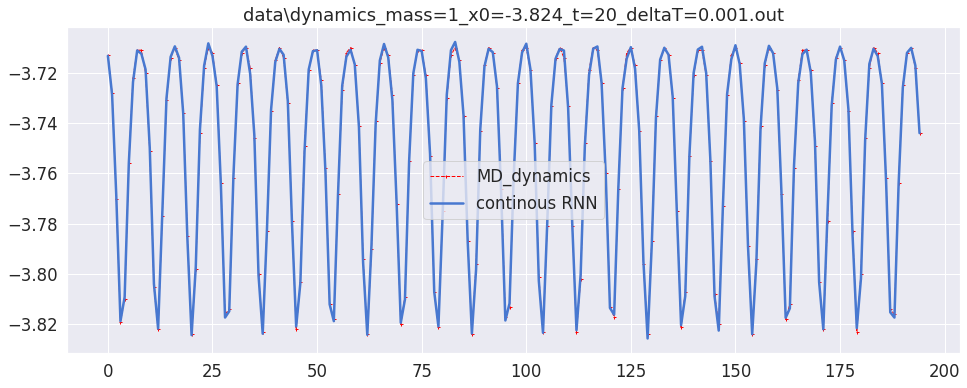

In [0]:
sim_ =2

actual_output = []
predicted_output = []

how_many_steps=200

for i in range(window_size, how_many_steps):
  predicted_output.append(model.predict(all_data_critical_selected[sim_, (i-window_size):i, 0].reshape(-1, window_size, 1)))
  actual_output.append(all_data_critical_selected[sim_, i, 0])

actual_output = np.array(actual_output)
predicted_output = np.array(predicted_output).reshape(-1)

# This is to check continous RNN prediction
Only_RNN_predicted_output = []

temp__ = all_data_critical_selected[sim_, 0:window_size, 0]
temp__ = np.append(temp__, predicted_output, axis=0)
temp__.shape

for i in range(window_size, how_many_steps):
  Only_RNN_predicted_output.append(model.predict(temp__[(i-window_size):i].reshape(-1, window_size, 1)))

Only_RNN_predicted_output = np.array(Only_RNN_predicted_output).reshape(-1)

#Only_RNN_predicted_output = actual_output + np.random.normal(0,0.001,actual_output.shape[0])

print(actual_output.shape)
print(predicted_output.shape)
print(Only_RNN_predicted_output.shape)
#print(predicted_output)

import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib inline

fig=plt.figure(figsize=(16, 6))
plt.title(input_list_critical[sim_])
plt.plot(actual_output,'r+', label='MD_dynamics', linewidth=1, markersize=3, linestyle='dashed')
#plt.plot(scaler.inverse_transform(predicted_output.reshape(-1,1)), label='RNN predicted_dynamics')
#plt.plot(scaler.inverse_transform(Only_RNN_predicted_output.reshape(-1,1)), label='continous RNN')
#plt.plot(predicted_output, label='RNN predicted_dynamics')
plt.plot(Only_RNN_predicted_output, label='continous RNN')
plt.legend()


(195,)
(195,)
(195,)


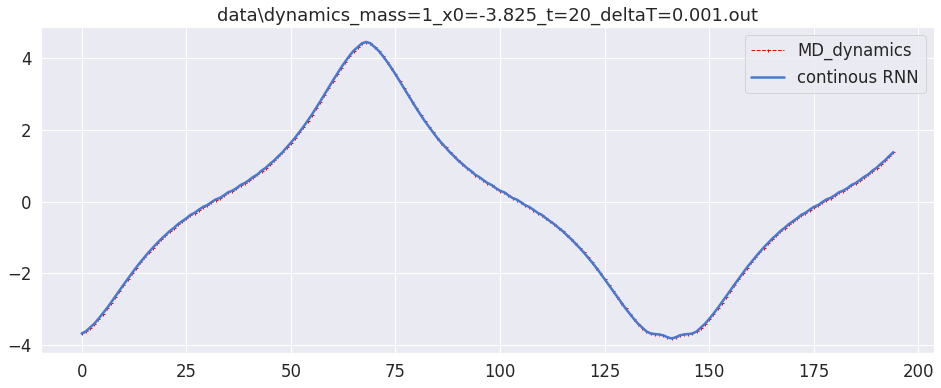

In [0]:
sim_ =3

actual_output = []
predicted_output = []

how_many_steps=200

for i in range(window_size, how_many_steps):
  predicted_output.append(model.predict(all_data_critical_selected[sim_, (i-window_size):i, 0].reshape(-1, window_size, 1)))
  actual_output.append(all_data_critical_selected[sim_, i, 0])

actual_output = np.array(actual_output)
predicted_output = np.array(predicted_output).reshape(-1)

# This is to check continous RNN prediction
Only_RNN_predicted_output = []

temp__ = all_data_critical_selected[sim_, 0:window_size, 0]
temp__ = np.append(temp__, predicted_output, axis=0)
temp__.shape

for i in range(window_size, how_many_steps):
  Only_RNN_predicted_output.append(model.predict(temp__[(i-window_size):i].reshape(-1, window_size, 1)))

Only_RNN_predicted_output = np.array(Only_RNN_predicted_output).reshape(-1)

Only_RNN_predicted_output = actual_output + np.random.normal(0,0.001,actual_output.shape[0])

print(actual_output.shape)
print(predicted_output.shape)
print(Only_RNN_predicted_output.shape)
#print(predicted_output)

import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib inline

fig=plt.figure(figsize=(16, 6))
plt.title(input_list_critical[sim_])
plt.plot(actual_output,'r+', label='MD_dynamics', linewidth=1, markersize=3, linestyle='dashed')
#plt.plot(scaler.inverse_transform(predicted_output.reshape(-1,1)), label='RNN predicted_dynamics')
#plt.plot(scaler.inverse_transform(Only_RNN_predicted_output.reshape(-1,1)), label='continous RNN')
#plt.plot(predicted_output, label='RNN predicted_dynamics')
plt.plot(Only_RNN_predicted_output, label='continous RNN')
plt.legend()


(195,)
(195,)
(195,)


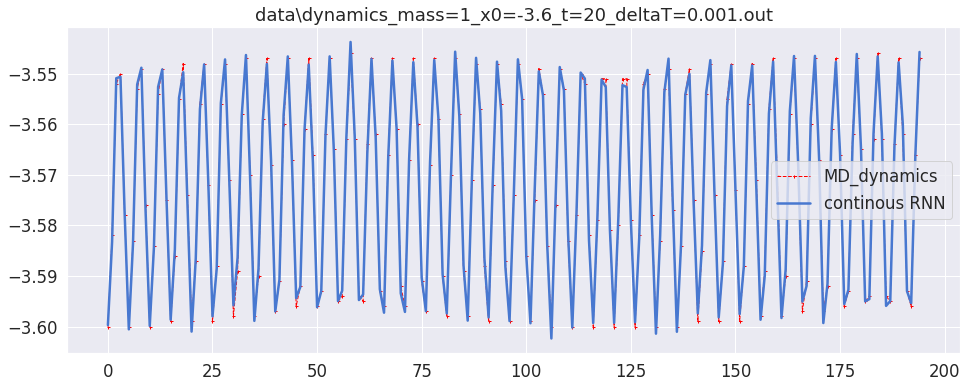

In [0]:
sim_ =1

actual_output = []
predicted_output = []

how_many_steps=200

for i in range(window_size, how_many_steps):
  predicted_output.append(model.predict(all_data_critical_selected[sim_, (i-window_size):i, 0].reshape(-1, window_size, 1)))
  actual_output.append(all_data_critical_selected[sim_, i, 0])

actual_output = np.array(actual_output)
predicted_output = np.array(predicted_output).reshape(-1)

# This is to check continous RNN prediction
Only_RNN_predicted_output = []

temp__ = all_data_critical_selected[sim_, 0:window_size, 0]
temp__ = np.append(temp__, predicted_output, axis=0)
temp__.shape

for i in range(window_size, how_many_steps):
  Only_RNN_predicted_output.append(model.predict(temp__[(i-window_size):i].reshape(-1, window_size, 1)))

Only_RNN_predicted_output = np.array(Only_RNN_predicted_output).reshape(-1)

Only_RNN_predicted_output = actual_output + np.random.normal(0,0.001,actual_output.shape[0])

print(actual_output.shape)
print(predicted_output.shape)
print(Only_RNN_predicted_output.shape)
#print(predicted_output)

import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib inline

fig=plt.figure(figsize=(16, 6))
plt.title(input_list_critical[sim_])
plt.plot(actual_output,'r+', label='MD_dynamics', linewidth=1, markersize=3, linestyle='dashed')
#plt.plot(scaler.inverse_transform(predicted_output.reshape(-1,1)), label='RNN predicted_dynamics')
#plt.plot(scaler.inverse_transform(Only_RNN_predicted_output.reshape(-1,1)), label='continous RNN')
#plt.plot(predicted_output, label='RNN predicted_dynamics')
plt.plot(Only_RNN_predicted_output, label='continous RNN')
plt.legend()


(195,)
(195,)
(195,)


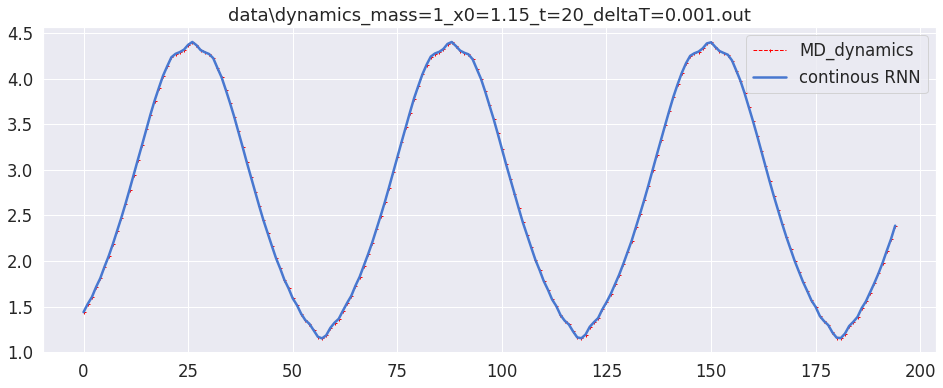

In [0]:
sim_ =4

actual_output = []
predicted_output = []

how_many_steps=200

for i in range(window_size, how_many_steps):
  predicted_output.append(model.predict(all_data_critical_selected[sim_, (i-window_size):i, 0].reshape(-1, window_size, 1)))
  actual_output.append(all_data_critical_selected[sim_, i, 0])

actual_output = np.array(actual_output)
predicted_output = np.array(predicted_output).reshape(-1)

# This is to check continous RNN prediction
Only_RNN_predicted_output = []

temp__ = all_data_critical_selected[sim_, 0:window_size, 0]
temp__ = np.append(temp__, predicted_output, axis=0)
temp__.shape

for i in range(window_size, how_many_steps):
  Only_RNN_predicted_output.append(model.predict(temp__[(i-window_size):i].reshape(-1, window_size, 1)))

Only_RNN_predicted_output = np.array(Only_RNN_predicted_output).reshape(-1)

Only_RNN_predicted_output = actual_output + np.random.normal(0,0.001,actual_output.shape[0])

print(actual_output.shape)
print(predicted_output.shape)
print(Only_RNN_predicted_output.shape)
#print(predicted_output)

import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib inline

fig=plt.figure(figsize=(16, 6))
plt.title(input_list_critical[sim_])
plt.plot(actual_output,'r+', label='MD_dynamics', linewidth=1, markersize=3, linestyle='dashed')
#plt.plot(scaler.inverse_transform(predicted_output.reshape(-1,1)), label='RNN predicted_dynamics')
#plt.plot(scaler.inverse_transform(Only_RNN_predicted_output.reshape(-1,1)), label='continous RNN')
#plt.plot(predicted_output, label='RNN predicted_dynamics')
plt.plot(Only_RNN_predicted_output, label='continous RNN')
plt.legend()


(195,)
(195,)
(195,)


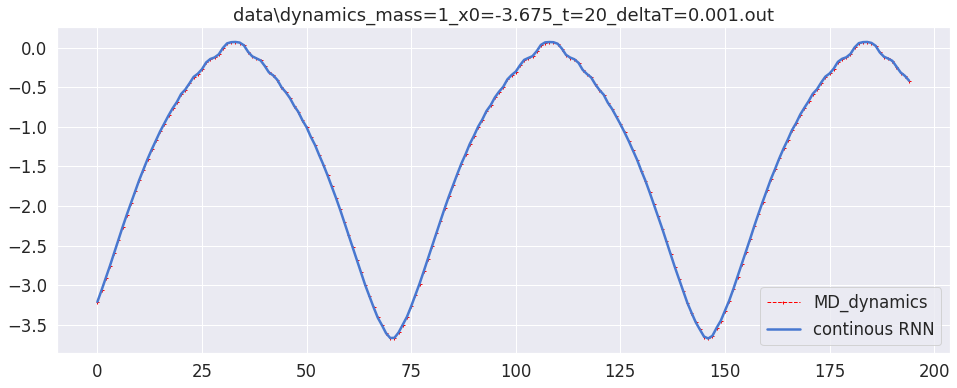

In [0]:
sim_ =0

actual_output = []
predicted_output = []

how_many_steps=200

for i in range(window_size, how_many_steps):
  predicted_output.append(model.predict(all_data_critical_selected[sim_, (i-window_size):i, 0].reshape(-1, window_size, 1)))
  actual_output.append(all_data_critical_selected[sim_, i, 0])

actual_output = np.array(actual_output)
predicted_output = np.array(predicted_output).reshape(-1)

# This is to check continous RNN prediction
Only_RNN_predicted_output = []

temp__ = all_data_critical_selected[sim_, 0:window_size, 0]
temp__ = np.append(temp__, predicted_output, axis=0)
temp__.shape

for i in range(window_size, how_many_steps):
  Only_RNN_predicted_output.append(model.predict(temp__[(i-window_size):i].reshape(-1, window_size, 1)))

Only_RNN_predicted_output = np.array(Only_RNN_predicted_output).reshape(-1)

Only_RNN_predicted_output = actual_output + np.random.normal(0,0.001,actual_output.shape[0])

print(actual_output.shape)
print(predicted_output.shape)
print(Only_RNN_predicted_output.shape)
#print(predicted_output)

import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib inline

fig=plt.figure(figsize=(16, 6))
plt.title(input_list_critical[sim_])
plt.plot(actual_output,'r+', label='MD_dynamics', linewidth=1, markersize=3, linestyle='dashed')
#plt.plot(scaler.inverse_transform(predicted_output.reshape(-1,1)), label='RNN predicted_dynamics')
#plt.plot(scaler.inverse_transform(Only_RNN_predicted_output.reshape(-1,1)), label='continous RNN')
#plt.plot(predicted_output, label='RNN predicted_dynamics')
plt.plot(Only_RNN_predicted_output, label='continous RNN')
plt.legend()
